<a href="https://colab.research.google.com/github/HenryKang1/Computer_vision_lecture_practice/blob/main/Interacting_with_CLIP%26CLIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 64 kB 1.5 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=589015f3fa17b21a0b5de31e90de5808c7a7a7bac53e0bda163a23c8b6c317b5
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8x4b1h52
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-8x4b1h52
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369090 sha256=6c4ed5d0cda98a4be155a7bd7c4c0c5854f1e9a9b2c37f2818af8daf320f9a8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-z97ex9p5/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 1.9.0+cu111


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 162MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fa9d76d7710>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [7]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

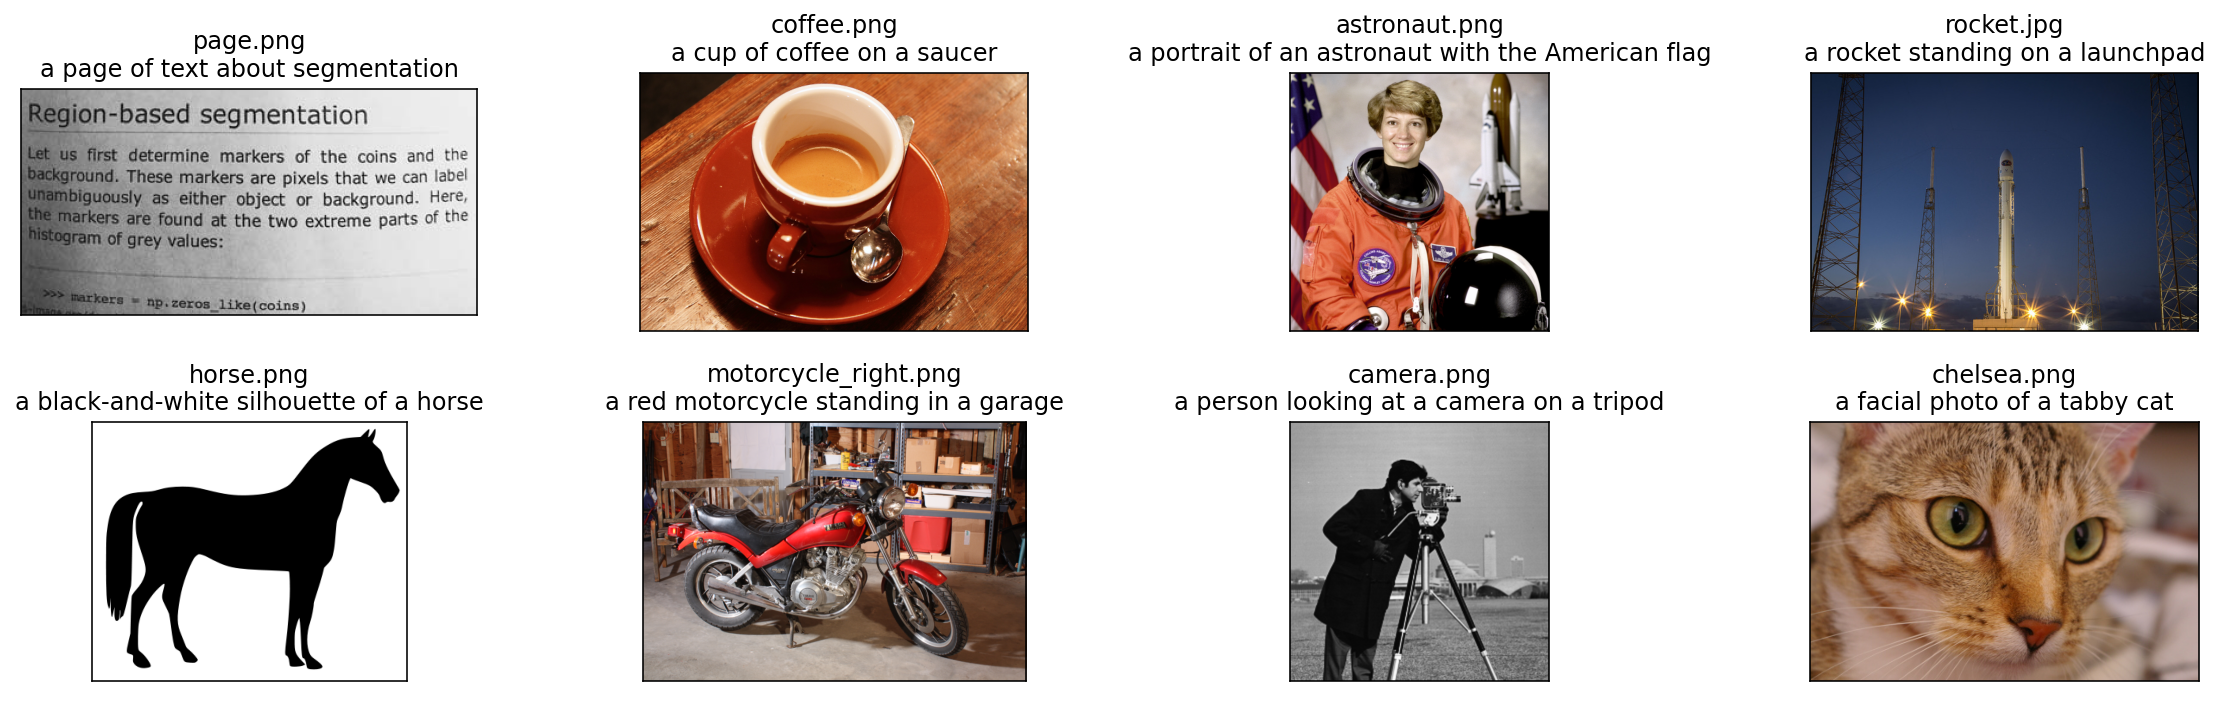

In [8]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [9]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [10]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [11]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

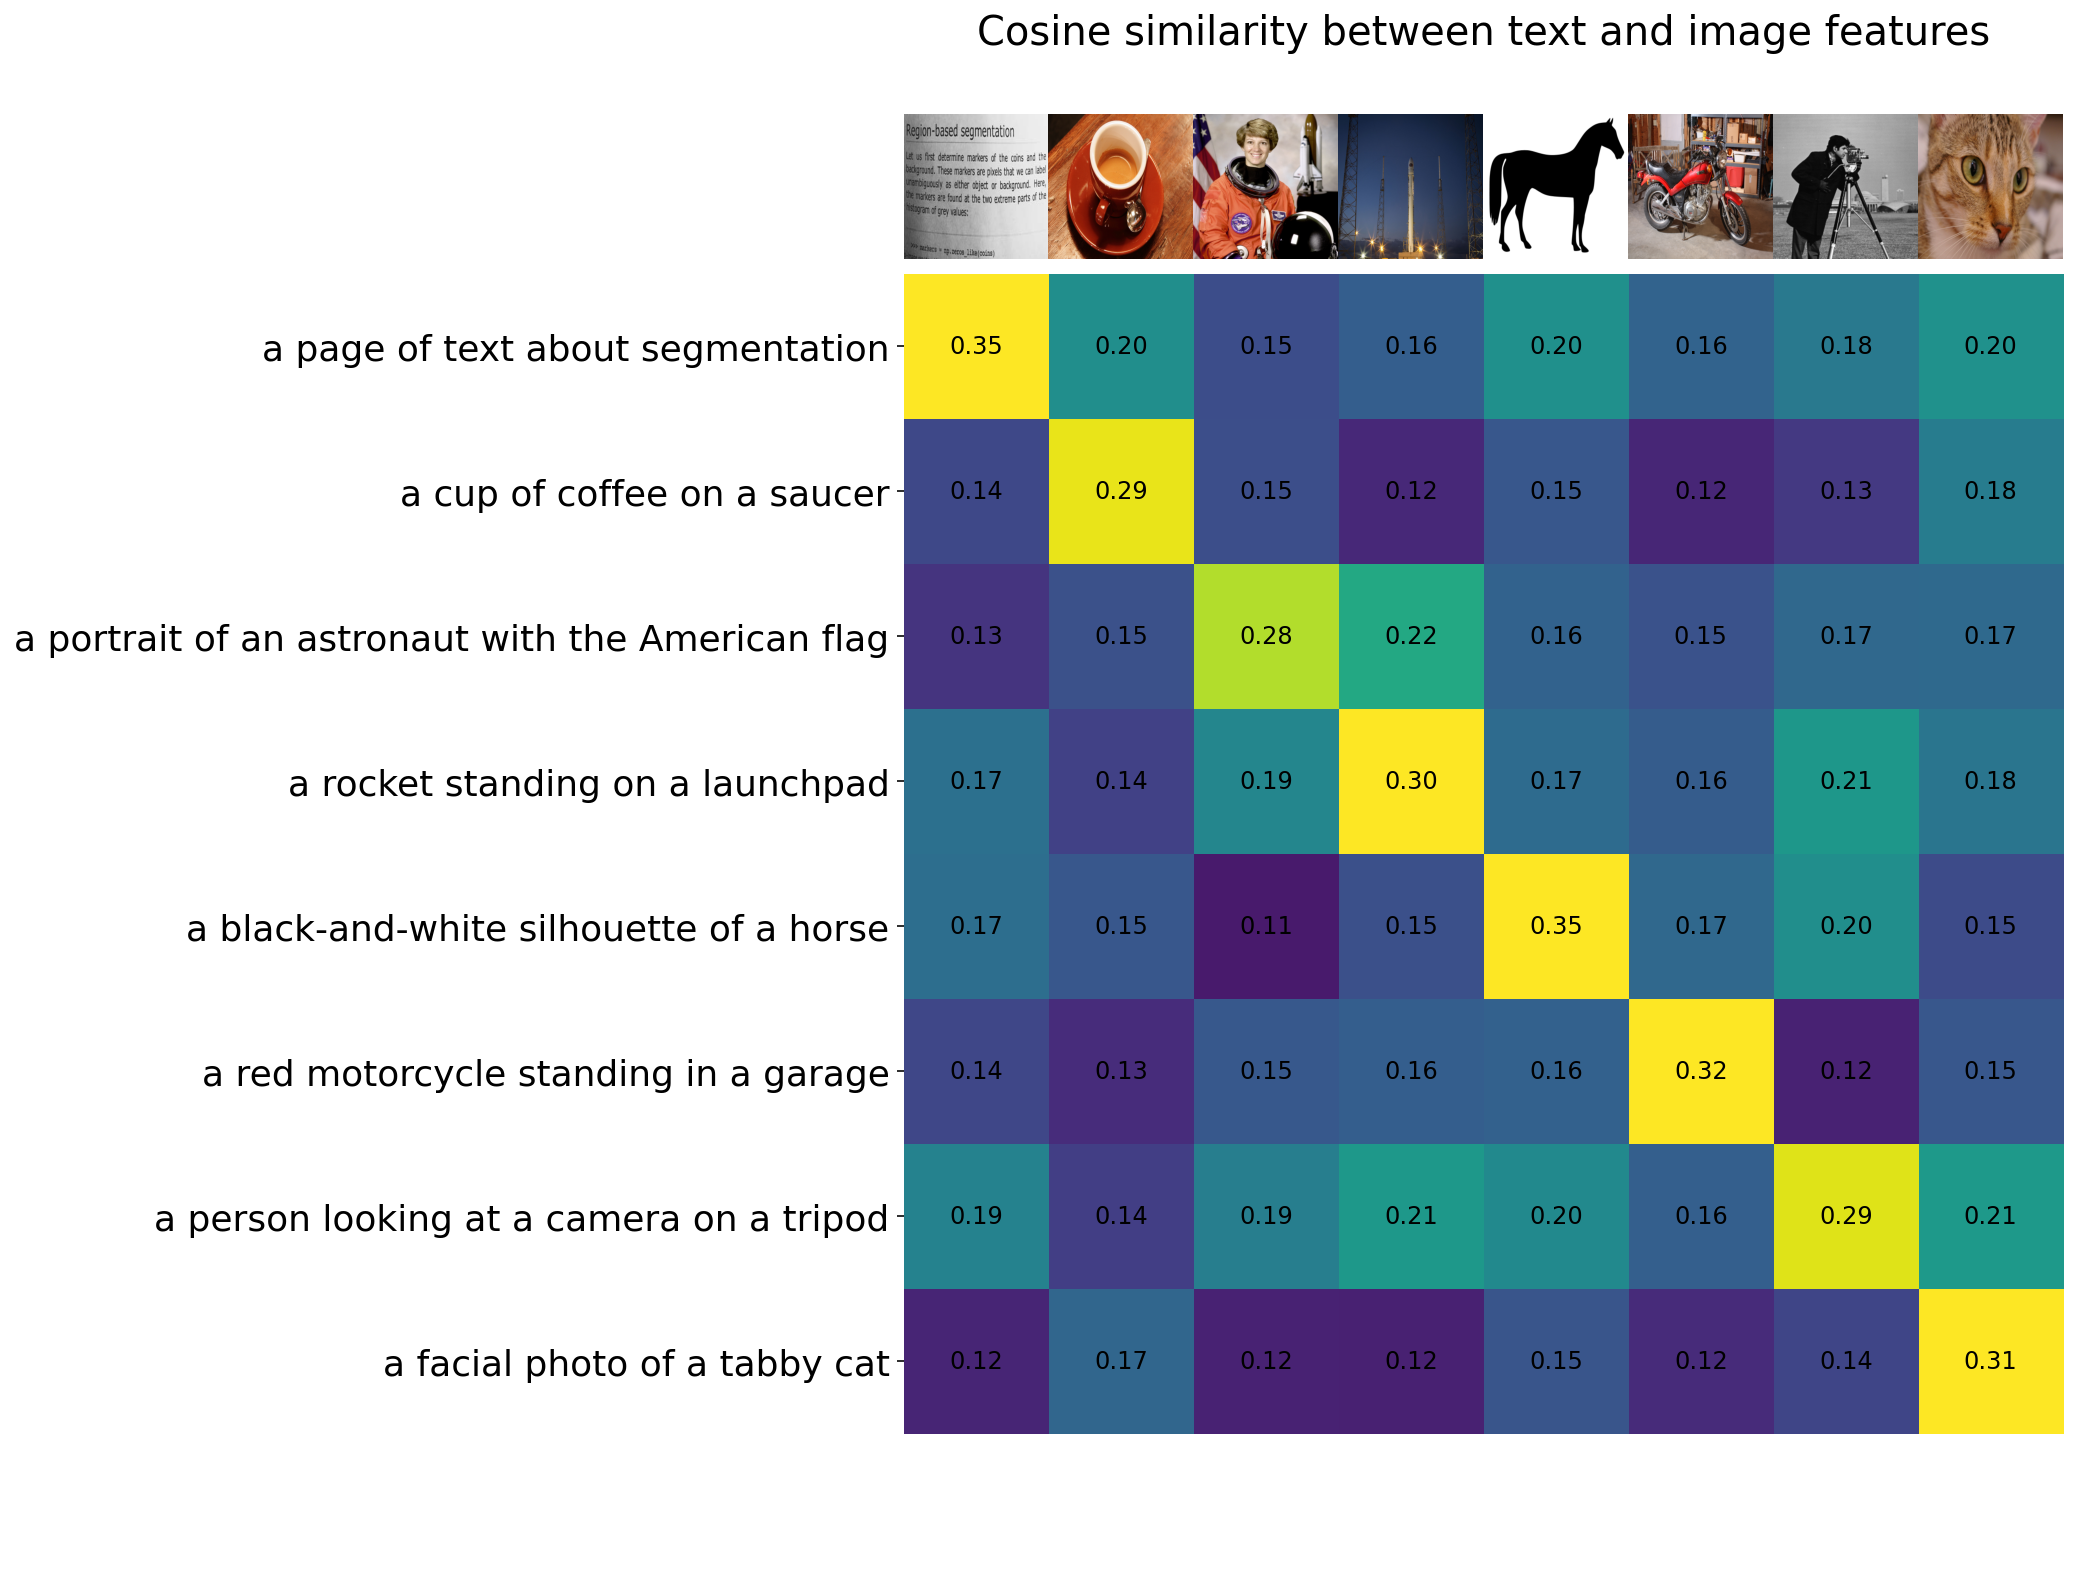

In [12]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [13]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [14]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [15]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

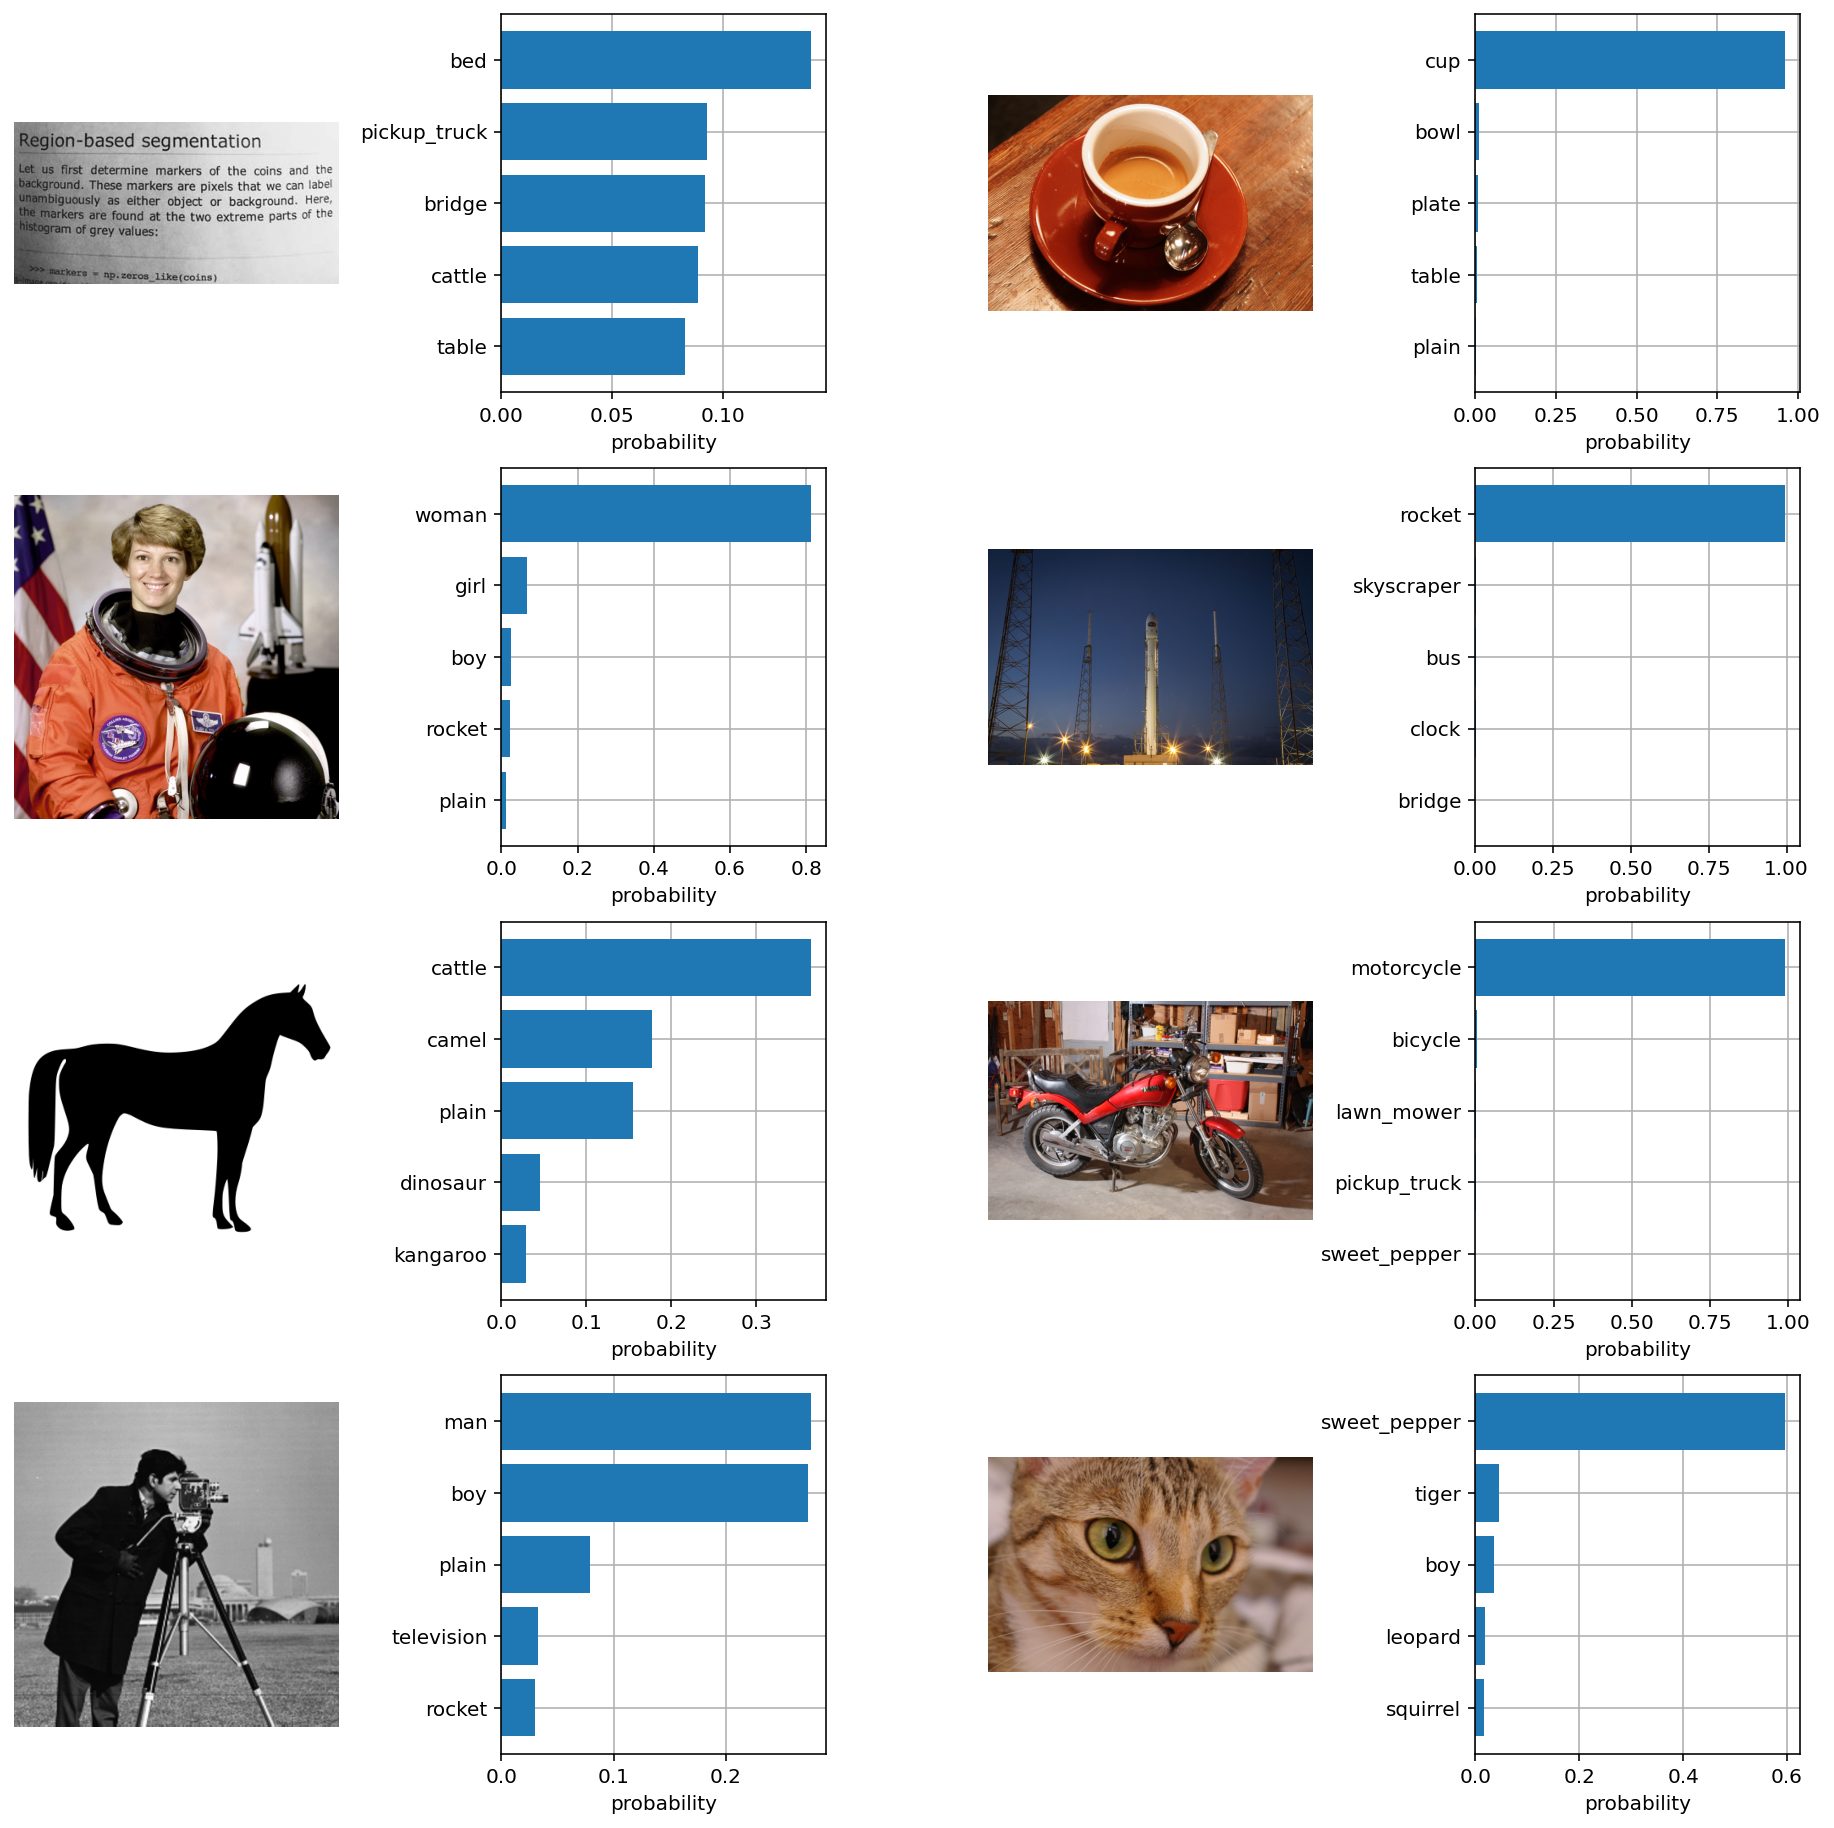

In [16]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [19]:
!pip install patchify



In [20]:
import os
import clip
import torch
import cv2
import math
import glob
import logging
import time

from PIL import Image
import numpy as np
from patchify import patchify

In [105]:


class CLIFS:
    def __init__(self):
        logging.basicConfig(format='%(asctime)s - %(message)s',
                            level=logging.INFO)


        # Choose device and load the chosen model
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
 #       self.model, self.preprocess = clip.load("ViT-B/32", self.device, jit=False)
        self.model, self.preprocess = clip.load("RN50x4", self.device, jit=False)

        self.image_features = None
        self.feature_idx_to_video = []

        # Preload the videos in the data input directory
        # This is done as upload through web interface isn't implemented yet
        #for f in glob.glob('{}/*'.format(os.getenv('./content/data/input/'))):
        self.add_video('./data/input/sherbrooke_video.avi')

        #self._write_image_from_match("./data/output/")
    def add_video(self, path, batch_size=512, ms_between_features=1000,
                  patch_size=360):
        # Calculates features from video images.
        # Loops over the input video to extract every frames_between_features
        # frame and calculate the features from it. The features are saved
        # along with mapping of what video and frame each detection
        # corresponds to.
        # The actual batch size can be up to batch_size + number of patches.
        logging.info('Adding video: {}'.format(path))
        cap = cv2.VideoCapture(path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frames_between_features = fps / (1000 / ms_between_features)
        feature_list = []
        feature_video_map = []

        frame_idx = 0
        to_encode = []
        while(cap.isOpened()):
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % frames_between_features == 0:
                patches = self._make_patches(frame, patch_size) + [frame]
                for idx, patch in enumerate(patches):
                    feature_data = {'video_path': path,
                                    'frame_idx': frame_idx,
                                    'time': frame_idx / fps}
                    feature_video_map.append(feature_data)
                    to_encode.append(patch)
            if len(to_encode) >= batch_size:
                image_features = self._calculate_images_features(to_encode)
                feature_list.append(image_features)
                to_encode = []

            frame_idx += 1
        if len(to_encode) > 0:
            image_features = self._calculate_images_features(to_encode)
            feature_list.append(image_features)
        feature_t = torch.cat(feature_list, dim=0)
        self._add_image_features(feature_t, feature_video_map)


    def _make_patches(self, frame, patch_size):
        # To get more information out of images, we divide the image
        # into smaller patches that are closer to the input size of the model
        step = int(patch_size / 2)
        patches_np = patchify(frame, (patch_size, patch_size, 3),
                              step=step)
        patches = []
        for i in range(patches_np.shape[0]):
            for j in range(patches_np.shape[1]):
                patches.append(patches_np[i, j, 0])
        return patches


    def _calculate_images_features(self, images):
        # Preprocess an image, send it to the computation device and perform
        # inference
        logging.info(f'Calculating features for batch of {len(images)} frames')
        for i in range(len(images)):
            t1 = time.time()
            images[i] = self._preprocess_image(images[i])
        t1 = time.time()
        image_stack = torch.stack(images, dim=0)
        image_t = image_stack.to(self.device)
        with torch.no_grad():
            image_features = self.model.encode_image(image_t)
        return image_features


    def _preprocess_image(self, image):
        # cv2 image to PIL image to the model's preprocess function
        # which makes sure the image is ok to ingest and makes it a tensor
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        return self.preprocess(image)


    def _add_image_features(self, new_features, feature_video_map):
        # Controls the addition of image features to the object
        # such that video mappings are provided, etc.,
        assert(new_features.shape[0] == len(feature_video_map))
        new_features /= new_features.norm(dim=-1, keepdim=True)
        if self.image_features is not None:
            self.image_features = torch.cat((self.image_features, new_features),
                                            dim=0)
        else:
            self.image_features = new_features
        self.feature_idx_to_video.extend(feature_video_map)


    def search(self, query, n=9, threshold=37):
        # Takes a query, calculates its features and finds the most similar
        # image features and thus corresponding images
        text_inputs = torch.cat([clip.tokenize(query)]).to(self.device)
        with torch.no_grad():
            text_features = self.model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * text_features @ self.image_features.T)

        # The 100 in n * 100 is just an arbitrary value to 1) find enough
        # matches to fill the results while 2) still being able to filter
        # the matches that stem from the same frame through the image patches
        # This could be made more efficient through keeping track of the indices
        # and matching these with the metadata in self.feature_idx_to_video
        values, indices = similarity[0].topk(n * 100)

        used_images = set()
        response_matches = []
        for indices_idx, similarity_idx in enumerate(indices):
            if len(response_matches) >= n:
                break
            initial_match_data = self.feature_idx_to_video[similarity_idx]
            score = float(values[indices_idx].cpu().numpy())
            img_hash = '{}-{}'.format(initial_match_data['video_path'],
                                      initial_match_data['frame_idx'])
            if img_hash in used_images:
                continue

            if score < threshold:
                # We've reached the point in the sorted list
                # where scores are too low
                if len(response_matches) == 0:
                    logging.info('No matches with score >= threshold found')
                break

            image_path = self._write_image_from_match(initial_match_data)
            if image_path is None:
                continue
            full_match_data = {
                               **initial_match_data,
                               'score': score,
                               'image_path': image_path,
                              }
            logging.info('Frame ({}): {}'.format(query, full_match_data))
            response_matches.append(full_match_data)
            used_images.add(img_hash)
        return response_matches


    def _write_image_from_match(self, match):
        path, ext = os.path.splitext(match['video_path'])
        video_name = os.path.splitext(os.path.basename(path))[0]
        image_name = '{}-{}.jpg'.format(video_name, match['frame_idx'])
        
        #image_path = '{}/{}'.format(os.getenv('./data/output/'), image_name)
        #if os.path.exists(image_path):
        #    return image_name
        cap = cv2.VideoCapture(match['video_path'])
        cap.set(cv2.CAP_PROP_POS_MSEC, match['time'] * 1000)
        ret, frame = cap.read()
        if not ret:
            return None
        cv2.imwrite("./data/output/"+image_name, frame)
        return image_name


In [100]:
path=os.getcwd()
video_path=path+"/data/"
print(video_path)

/content/data/


In [106]:
clifs=CLIFS()


2021-10-18 15:41:33,424 - Adding video: ./data/input/sherbrooke_video.avi
2021-10-18 15:41:36,627 - Calculating features for batch of 518 frames
2021-10-18 15:41:42,203 - Calculating features for batch of 420 frames


In [109]:
resutl_list=clifs.search("A white BMW car")

2021-10-18 15:42:24,115 - Frame (A white BMW car): {'video_path': './data/input/sherbrooke_video.avi', 'frame_idx': 2340, 'time': 78.0, 'score': 37.625, 'image_path': 'sherbrooke_video-2340.jpg'}
2021-10-18 15:42:24,191 - Frame (A white BMW car): {'video_path': './data/input/sherbrooke_video.avi', 'frame_idx': 30, 'time': 1.0, 'score': 37.4375, 'image_path': 'sherbrooke_video-30.jpg'}


In [110]:
resutl_list

[{'frame_idx': 2340,
  'image_path': 'sherbrooke_video-2340.jpg',
  'score': 37.625,
  'time': 78.0,
  'video_path': './data/input/sherbrooke_video.avi'},
 {'frame_idx': 30,
  'image_path': 'sherbrooke_video-30.jpg',
  'score': 37.4375,
  'time': 1.0,
  'video_path': './data/input/sherbrooke_video.avi'}]

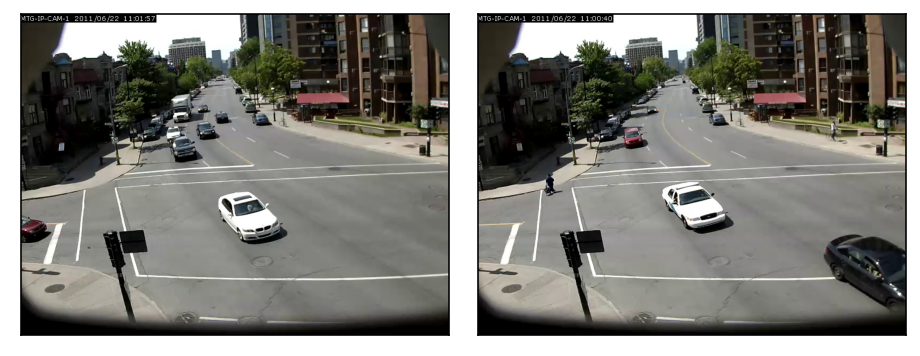

In [111]:
plt.figure(figsize=(16, 5))
img_path="./data/output/"
img_pathl=os.listdir("./data/output/")
images=[]
for i in img_pathl:
  name =i
  image=Image.open(img_path+name).convert("RGB")
  plt.subplot(2,5,len(images)+1)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  images.append(preprocess(image))  
plt.tight_layout()

In [80]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


TypeError: ignored